# Pred_Hackathon_2023_Team_VAM_10052023

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout,LSTM
from keras.models import Sequential
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pprint import pprint
from pycaret.internal.pycaret_experiment import TimeSeriesExperiment
from sktime.utils.plotting import plot_series
from pycaret import time_series as ts
from pycaret.time_series import TSForecastingExperiment
#https://www.kaggle.com/code/gauravduttakiit/time-forecasting-using-pycaret

#  1. Unempolyment rate in Italy 

### A. Reading the input files 

In [2]:

# Reading the data file 
df=pd.read_csv("Italy.csv")
#df=pd.read_csv("usa.csv")
#df=pd.read_csv("japan.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

### B. Plot analysis 

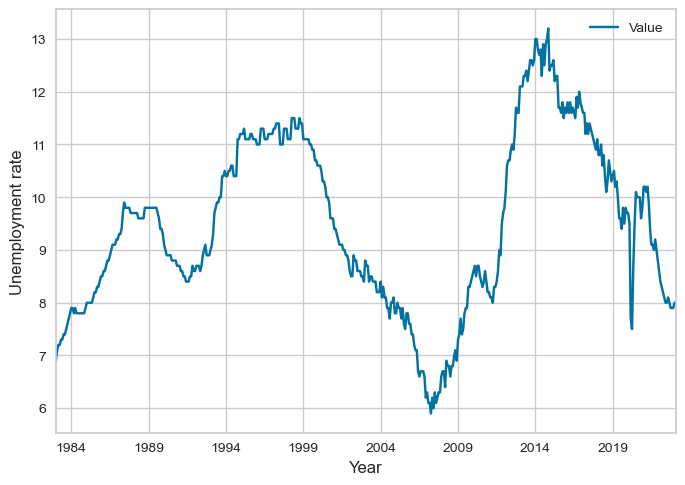

<Figure size 800x600 with 0 Axes>

In [3]:

df.plot()
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.figure(figsize=(8, 6))
plt.show()

### C. Machine learning model comparision 

In [5]:
# Pycaret algorith
exp = TSForecastingExperiment()
exp.setup(data=df['Value'],session_id=42,fh=12)

# compare models 
exp.compare_models(sort='mae')

,Description,Value
0,session_id,42
1,Target,Value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(482, 1)"
5,Transformed data shape,"(482, 1)"
6,Transformed train set shape,"(470, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
grand_means,Grand Means Forecaster,1.1410,1.0914,0.5099,0.6327,0.0565,0.0548,-0.3719,9.8467
snaive,Seasonal Naive Forecaster,1.5797,1.4894,0.7056,0.8650,0.0785,0.0741,-2.8862,0.9633
croston,Croston,1.7138,1.6331,0.7626,0.9434,0.0848,0.0793,-4.7139,0.4733
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.7135,1.6658,0.7669,0.9692,0.0862,0.0802,-3.4952,4.6433
naive,Naive Forecaster,1.8021,1.6135,0.8056,0.9385,0.0890,0.0841,-3.5750,16.7700
theta,Theta Forecaster,1.8108,1.6243,0.8096,0.9450,0.0895,0.0845,-3.6769,10.6800
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.8164,1.6002,0.8122,0.9312,0.0895,0.0849,-3.3740,3.9933
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.8229,1.6608,0.8149,0.9660,0.0903,0.0849,-4.0231,1.3733
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.8229,1.6608,0.8149,0.9660,0.0903,0.0849,-4.0231,13.8533
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.8238,1.6633,0.8153,0.9675,0.0903,0.0849,-4.0193,1.8467


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

NaiveForecaster(strategy='mean')

In [6]:
## Create a model manually
#model = exp.create_model("grand_means")
model = exp.create_model("arima")
model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-02,1.1227,1.0404,0.4923,0.5910,0.0511,0.0494,-3.8220
1,2020-02,1.5189,1.5460,0.6707,0.8816,0.0779,0.0737,0.0699
2,2021-02,2.9569,2.4905,1.3543,1.4991,0.1509,0.1379,-6.5184
Mean,NaT,1.8662,1.6923,0.8391,0.9906,0.0933,0.0870,-3.4235
SD,NaT,0.7880,0.6010,0.3715,0.3786,0.0422,0.0373,2.7044


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ARIMA(seasonal_order=(0, 1, 0, 8))

In [7]:
y_train = exp.get_config("y_train")
#y_train[0:int(len(df)*0.80)]

In [8]:
y_predict = exp.predict_model(model)
#plot_series(df['Value'], y_train, y_predict, labels=['All', 'Train', 'Test Predictions'])
#plt.grid()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,0.3873,0.3873,0.1804,0.2366,0.0225,0.0221,-3.0311


In [9]:
tuned_model = exp.tune_model(model)
tuned_model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-02,1.3231,1.1802,0.5802,0.6704,0.0602,0.0579,-5.2049
1,2020-02,2.2364,1.9455,0.9875,1.1095,0.1096,0.1077,-0.4728
2,2021-02,1.4614,1.4050,0.6693,0.8457,0.0752,0.0710,-1.3926
Mean,NaT,1.6736,1.5102,0.7457,0.8752,0.0817,0.0788,-2.3568
SD,NaT,0.4019,0.3212,0.1748,0.1805,0.0207,0.0211,2.0486


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   49.5s finished


ARIMA(order=(1, 0, 1), seasonal_order=(1, 1, 0, 16), with_intercept=False)

In [10]:
exp.predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,1.0119,0.8830,0.4714,0.5395,0.0590,0.0589,-19.9592


,y_pred
2022-03,8.2652
2022-04,8.2460
2022-05,8.6682
2022-06,8.5087
2022-07,8.6719
2022-08,8.6722
2022-09,8.5742
2022-10,8.2760
2022-11,7.0893
2022-12,6.9882


In [11]:
# Finalize Model
final_model = exp.finalize_model(tuned_model)
# Future Predictions
y_pred_future = exp.predict_model(final_model, verbose=False)

In [12]:
y_pred_future

,y_pred
2023-03,8.2396
2023-04,8.1191
2023-05,8.0515
2023-06,7.9835
2023-07,7.7477
2023-08,7.8322
2023-09,8.0231
2023-10,7.9997
2023-11,7.9690
2023-12,8.0913


###  D. LSTM model analysis 


###  D.1 Reading the input files 

In [2]:

# Reading the data file 
df=pd.read_csv("Italy.csv")
#df=pd.read_csv("usa.csv")
#df=pd.read_csv("japan.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

###  D.2 Rolling means 6 months 

In [6]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(6,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-6:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_6_days=df_train.tail(6)
final_df=past_6_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(6,input_data.shape[0]):
    x_test.append(input_data[i-6:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_6=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_6["Upper_Bound"]=final_pred_6["Closing_Price"]+interval
final_pred_6["Lower_Bound"]=final_pred_6["Closing_Price"]-interval


print(final_pred_6)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
379/379 [==============================] - 15s 10ms/step - loss: 0.0055
Epoch 2/3
379/379 [==============================] - 4s 9ms/step - loss: 0.0027
Epoch 3/3
1/1 [==============================] - 0s 52ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       7.827041     7.910002     7.744080
1       7.796852     7.879813     7.713891
2       7.766555     7.849516     7.683593
3       7.738607     7.821568     7.655646
4       7.706539     7.789500     7.623578
The Mean Squared Error is 0.077252
The Root Mean Squared Error is 0.077252


###  D.3 Rolling means 3 months 

In [7]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(3,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-3:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_3_days=df_train.tail(3)
final_df=past_3_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(3,input_data.shape[0]):
    x_test.append(input_data[i-3:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_3=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_3["Upper_Bound"]=final_pred_3["Closing_Price"]+interval
final_pred_3["Lower_Bound"]=final_pred_3["Closing_Price"]-interval


print(final_pred_3)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
382/382 [==============================] - 16s 9ms/step - loss: 0.0067
Epoch 2/3
382/382 [==============================] - 3s 7ms/step - loss: 0.0018
Epoch 3/3
1/1 [==============================] - 0s 54ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       7.970445     8.038843     7.902047
1       7.999125     8.067523     7.930727
2       8.037633     8.106031     7.969234
3       8.042727     8.111125     7.974329
4       8.069449     8.137847     8.001051
The Mean Squared Error is 0.080094
The Root Mean Squared Error is 0.080094


###  D.4 Rolling means - 1 month

In [8]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(1,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-1:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_1_days=df_train.tail(1)
final_df=past_1_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(1,input_data.shape[0]):
    x_test.append(input_data[i-1:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_1=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_1["Upper_Bound"]=final_pred_1["Closing_Price"]+interval
final_pred_1["Lower_Bound"]=final_pred_1["Closing_Price"]-interval


print(final_pred_1)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
384/384 [==============================] - 9s 6ms/step - loss: 0.0164
Epoch 2/3
384/384 [==============================] - 3s 7ms/step - loss: 9.6679e-04
Epoch 3/3
1/1 [==============================] - 0s 49ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       7.993518     8.007398     7.979637
1       7.987689     8.001569     7.973808
2       7.982448     7.996329     7.968568
3       7.977738     7.991618     7.963857
4       7.973504     7.987385     7.959624
The Mean Squared Error is 0.064268
The Root Mean Squared Error is 0.064268


#  2. Unempolyment rate in Japan

### A. Reading the input files 

In [9]:

# Reading the data file 
df=pd.read_csv("japan.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

### B. Plot analysis 

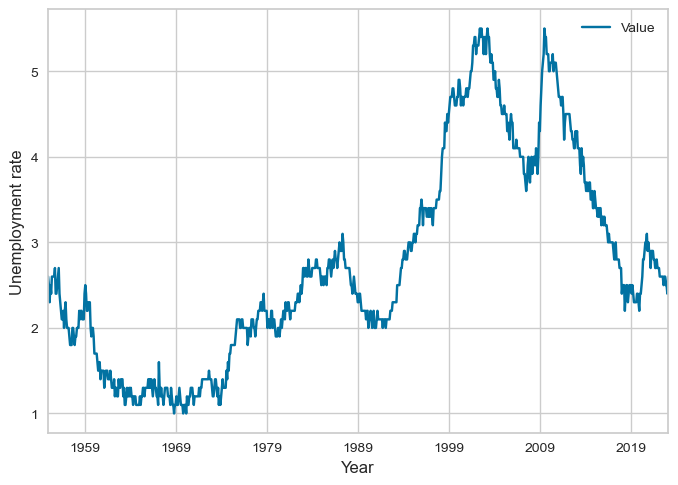

<Figure size 800x600 with 0 Axes>

In [10]:

df.plot()
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.figure(figsize=(8, 6))
plt.show()

### C. Machine learning model comparision 

In [11]:
# Pycaret algorith
exp = TSForecastingExperiment()
exp.setup(data=df['Value'],session_id=42,fh=12)

# compare models 
exp.compare_models(sort='mae')

,Description,Value
0,session_id,42
1,Target,Value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(818, 1)"
5,Transformed data shape,"(818, 1)"
6,Transformed train set shape,"(806, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
naive,Naive Forecaster,0.3287,0.2998,0.2194,0.2454,0.0783,0.0827,-3.5671,7.8133
grand_means,Grand Means Forecaster,0.3311,0.2857,0.2203,0.2336,0.0874,0.0834,-9.2099,2.5867
theta,Theta Forecaster,0.3425,0.3072,0.2286,0.2515,0.0825,0.0869,-3.7852,4.4300
croston,Croston,0.3667,0.3201,0.2447,0.2620,0.0899,0.0938,-4.8165,2.8100
arima,ARIMA,0.3790,0.3502,0.2530,0.2866,0.0903,0.0982,-5.1950,2.6867
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.4281,0.3741,0.2854,0.3060,0.1044,0.1076,-6.6112,1.5267
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.4296,0.3750,0.2865,0.3068,0.1049,0.1088,-6.4725,2.3900
exp_smooth,Exponential Smoothing,0.4327,0.3905,0.2888,0.3196,0.1025,0.1113,-6.7287,1.4833
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.4614,0.3996,0.3076,0.3270,0.1124,0.1166,-7.5602,2.0467
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.4622,0.4027,0.3083,0.3295,0.1118,0.1175,-7.4306,3.4000


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

NaiveForecaster()

In [25]:
## Create a model manually
model = exp.create_model("naive")
model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-02,0.1004,0.1118,0.0667,0.0913,0.0290,0.0284,-0.4286
1,2020-02,0.6971,0.6036,0.4667,0.4950,0.1598,0.1754,-8.0000
2,2021-02,0.1887,0.1841,0.1250,0.1500,0.0460,0.0445,-2.2727
Mean,NaT,0.3287,0.2998,0.2194,0.2454,0.0783,0.0827,-3.5671
SD,NaT,0.2630,0.2168,0.1764,0.1781,0.0581,0.0658,3.2237


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

NaiveForecaster()

In [26]:
y_train = exp.get_config("y_train")
#y_train[0:int(len(df)*0.80)]

In [27]:
y_predict = exp.predict_model(model)
#plot_series(df['Value'], y_train, y_predict, labels=['All', 'Train', 'Test Predictions'])
#plt.grid()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Naive Forecaster,0.2168,0.1923,0.1417,0.1555,0.0561,0.0542,-4.8983


In [28]:
tuned_model = exp.tune_model(model)
tuned_model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-02,0.1004,0.1118,0.0667,0.0913,0.0290,0.0284,-0.4286
1,2020-02,0.6971,0.6036,0.4667,0.4950,0.1598,0.1754,-8.0000
2,2021-02,0.1887,0.1841,0.1250,0.1500,0.0460,0.0445,-2.2727
Mean,NaT,0.3287,0.2998,0.2194,0.2454,0.0783,0.0827,-3.5671
SD,NaT,0.2630,0.2168,0.1764,0.1781,0.0581,0.0658,3.2237


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished


NaiveForecaster()

In [29]:
exp.predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Naive Forecaster,0.2168,0.1923,0.1417,0.1555,0.0561,0.0542,-4.8983


,y_pred
2022-03,2.7
2022-04,2.7
2022-05,2.7
2022-06,2.7
2022-07,2.7
2022-08,2.7
2022-09,2.7
2022-10,2.7
2022-11,2.7
2022-12,2.7


In [30]:
# Finalize Model
final_model = exp.finalize_model(tuned_model)
# Future Predictions
y_pred_future = exp.predict_model(final_model, verbose=False)

In [31]:
y_pred_future

,y_pred
2023-03,2.6
2023-04,2.6
2023-05,2.6
2023-06,2.6
2023-07,2.6
2023-08,2.6
2023-09,2.6
2023-10,2.6
2023-11,2.6
2023-12,2.6


###  D. LSTM model analysis 


###  D.1 Reading the input files 

In [19]:

# Reading the data file 
df=pd.read_csv("japan.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

###  D.2 Rolling means 6 months 

In [20]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(6,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-6:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_6_days=df_train.tail(6)
final_df=past_6_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(6,input_data.shape[0]):
    x_test.append(input_data[i-6:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_6=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_6["Upper_Bound"]=final_pred_6["Closing_Price"]+interval
final_pred_6["Lower_Bound"]=final_pred_6["Closing_Price"]-interval


print(final_pred_6)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
648/648 [==============================] - 12s 11ms/step - loss: 0.0036
Epoch 2/3
648/648 [==============================] - 7s 11ms/step - loss: 0.0022
Epoch 3/3
1/1 [==============================] - 0s 33ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       2.566960     2.579817     2.554102
1       2.567589     2.580446     2.554731
2       2.566780     2.579638     2.553923
3       2.569824     2.582682     2.556967
4       2.583962     2.596820     2.571105
The Mean Squared Error is 0.047482
The Root Mean Squared Error is 0.047482


###  D.3 Rolling means 3 months 

In [23]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(3,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-3:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_3_days=df_train.tail(3)
final_df=past_3_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(3,input_data.shape[0]):
    x_test.append(input_data[i-3:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_3=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_3["Upper_Bound"]=final_pred_3["Closing_Price"]+interval
final_pred_3["Lower_Bound"]=final_pred_3["Closing_Price"]-interval


print(final_pred_3)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
651/651 [==============================] - 12s 7ms/step - loss: 0.0039
Epoch 2/3
651/651 [==============================] - 4s 6ms/step - loss: 0.0018
Epoch 3/3
1/1 [==============================] - 0s 31ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       2.450945     2.498529     2.403361
1       2.426193     2.473777     2.378609
2       2.396405     2.443989     2.348821
3       2.402251     2.449835     2.354667
4       2.382143     2.429727     2.334559
The Mean Squared Error is 0.037535
The Root Mean Squared Error is 0.037535


###  D.4 Rolling means - 1 month

In [24]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(1,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-1:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_1_days=df_train.tail(1)
final_df=past_1_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(1,input_data.shape[0]):
    x_test.append(input_data[i-1:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_1=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_1["Upper_Bound"]=final_pred_1["Closing_Price"]+interval
final_pred_1["Lower_Bound"]=final_pred_1["Closing_Price"]-interval


print(final_pred_1)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
653/653 [==============================] - 10s 6ms/step - loss: 0.0067
Epoch 2/3
653/653 [==============================] - 4s 5ms/step - loss: 0.0010
Epoch 3/3
1/1 [==============================] - 0s 27ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       2.443343     2.545556     2.341130
1       2.483883     2.586096     2.381670
2       2.521844     2.624057     2.419631
3       2.557427     2.659640     2.455214
4       2.590813     2.693026     2.488600
The Mean Squared Error is 0.034399
The Root Mean Squared Error is 0.034399


#  3. Unempolyment rate in USA

### A. Reading the input files 

In [32]:

# Reading the data file 
df=pd.read_csv("usa.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

### B. Plot analysis 

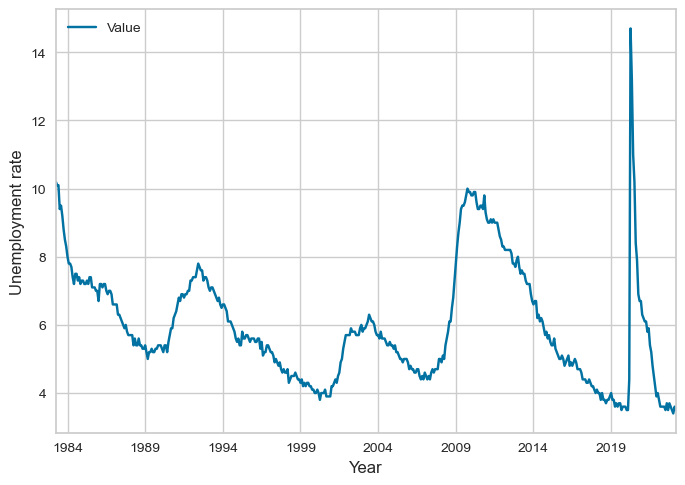

<Figure size 800x600 with 0 Axes>

In [33]:

df.plot()
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.figure(figsize=(8, 6))
plt.show()

### C. Machine learning model comparision 

In [34]:
# Pycaret algorith
exp = TSForecastingExperiment()
exp.setup(data=df['Value'],session_id=42,fh=12)

# compare models 
exp.compare_models(sort='mae')

,Description,Value
0,session_id,42
1,Target,Value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(480, 1)"
5,Transformed data shape,"(480, 1)"
6,Transformed train set shape,"(468, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,13.5188,11.3453,1.6971,2.2153,0.2351,0.2563,-1.4629,0.0767
ets,ETS,13.5188,11.3452,1.6971,2.2153,0.2351,0.2563,-1.4628,0.0900
auto_arima,Auto ARIMA,14.1963,11.5391,1.7827,2.2663,0.2534,0.2734,-1.6886,6.8300
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,14.9123,11.5600,1.8336,2.1494,0.2471,0.2886,-1.0652,0.2600
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,15.3971,11.8551,1.9079,2.2656,0.2650,0.3010,-1.4279,0.2767
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,15.2534,11.7337,1.9099,2.3028,0.2736,0.2982,-1.7524,0.3533
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,15.3983,11.8549,1.9101,2.2730,0.2673,0.3014,-1.5043,0.2467
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,15.3989,11.8550,1.9102,2.2731,0.2673,0.3014,-1.5043,0.2467
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,15.3989,11.8550,1.9102,2.2731,0.2673,0.3014,-1.5043,0.3333
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,15.3989,11.8550,1.9102,2.2731,0.2673,0.3014,-1.5043,0.9133


Processing:   0%|          | 0/113 [00:00<?, ?it/s]

ExponentialSmoothing(sp=1, trend='add')

In [46]:
## Create a model manually
model = exp.create_model("exp_smooth")
model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,1.5494,1.5976,0.1812,0.2559,0.0474,0.0480,-0.2154
1,2020-03,30.8391,29.6050,3.6339,4.8725,0.3502,0.4708,-2.0139
2,2021-03,8.1679,2.8333,1.2763,1.5175,0.3077,0.2501,-2.1594
Mean,NaT,13.5188,11.3453,1.6971,2.2153,0.2351,0.2563,-1.4629
SD,NaT,12.5418,12.9214,1.4406,1.9482,0.1338,0.1727,0.8841


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ExponentialSmoothing(sp=1, trend='add')

In [47]:
y_train = exp.get_config("y_train")
#y_train[0:int(len(df)*0.80)]

In [48]:
y_predict = exp.predict_model(model)
#plot_series(df['Value'], y_train, y_predict, labels=['All', 'Train', 'Test Predictions'])
#plt.grid()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.4928,0.1882,0.0781,0.0998,0.0216,0.0220,-0.3799


In [49]:
tuned_model = exp.tune_model(model)
tuned_model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,1.5755,1.5950,0.1842,0.2555,0.0483,0.0489,-0.2115
1,2020-03,28.5155,28.7866,3.3601,4.7378,0.3135,0.4207,-1.8495
2,2021-03,7.2075,2.5117,1.1263,1.3453,0.2720,0.2256,-1.4830
Mean,NaT,12.4328,10.9645,1.5569,2.1129,0.2113,0.2317,-1.1813
SD,NaT,11.6023,12.6077,1.3318,1.9087,0.1165,0.1518,0.7019


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished


ExponentialSmoothing(trend='mul', use_boxcox=False)

In [50]:
exp.predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.6798,0.2604,0.1077,0.1382,0.0298,0.0306,-1.6432


,y_pred
2022-04,3.5782
2022-05,3.5565
2022-06,3.5349
2022-07,3.5135
2022-08,3.4921
2022-09,3.4710
2022-10,3.4499
2022-11,3.4290
2022-12,3.4082
2023-01,3.3875


In [51]:
# Finalize Model
final_model = exp.finalize_model(tuned_model)
# Future Predictions
y_pred_future = exp.predict_model(final_model, verbose=False)

In [52]:
y_pred_future

,y_pred
2023-04,3.4788
2023-05,3.4578
2023-06,3.4369
2023-07,3.4161
2023-08,3.3954
2023-09,3.3748
2023-10,3.3544
2023-11,3.3341
2023-12,3.3140
2024-01,3.2939


###  D. LSTM model analysis 


###  D.1 Reading the input files 

In [183]:

# Reading the data file 
df=pd.read_csv("usa.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

###  D.2 Rolling means 6 months 

In [187]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(6,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-6:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_6_days=df_train.tail(6)
final_df=past_6_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(6,input_data.shape[0]):
    x_test.append(input_data[i-6:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_6=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_6["Upper_Bound"]=final_pred_6["Closing_Price"]+interval
final_pred_6["Lower_Bound"]=final_pred_6["Closing_Price"]-interval


print(final_pred_6)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
378/378 [==============================] - 10s 9ms/step - loss: 0.0081
Epoch 2/3
378/378 [==============================] - 4s 10ms/step - loss: 0.0039
Epoch 3/3
1/1 [==============================] - 0s 30ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       3.719334     3.874444     3.564224
1       3.761205     3.916316     3.606095
2       3.813021     3.968131     3.657910
3       3.874884     4.029995     3.719774
4       3.941165     4.096276     3.786055
The Mean Squared Error is 0.129123
The Root Mean Squared Error is 0.129123


###  D.3 Rolling means 3 months 

In [188]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(3,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-3:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_3_days=df_train.tail(3)
final_df=past_3_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(3,input_data.shape[0]):
    x_test.append(input_data[i-3:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_3=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_3["Upper_Bound"]=final_pred_3["Closing_Price"]+interval
final_pred_3["Lower_Bound"]=final_pred_3["Closing_Price"]-interval


print(final_pred_3)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
381/381 [==============================] - 9s 7ms/step - loss: 0.0090
Epoch 2/3
381/381 [==============================] - 2s 6ms/step - loss: 0.0030
Epoch 3/3
1/1 [==============================] - 0s 53ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       2.944855     3.583169     2.306542
1       2.830715     3.469029     2.192402
2       2.653719     3.292032     2.015405
3       2.282959     2.921273     1.644646
4       2.087379     2.725693     1.449066
The Mean Squared Error is 0.138352
The Root Mean Squared Error is 0.138352


###  D.4 Rolling means - 1 month

In [190]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(1,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-1:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_1_days=df_train.tail(1)
final_df=past_1_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(1,input_data.shape[0]):
    x_test.append(input_data[i-1:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_1=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_1["Upper_Bound"]=final_pred_1["Closing_Price"]+interval
final_pred_1["Lower_Bound"]=final_pred_1["Closing_Price"]-interval


print(final_pred_1)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
383/383 [==============================] - 18s 8ms/step - loss: 0.0113
Epoch 2/3
383/383 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 3/3
1/1 [==============================] - 0s 31ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       3.612852     3.646141     3.579562
1       3.625356     3.658645     3.592066
2       3.637523     3.670812     3.604233
3       3.649364     3.682653     3.616074
4       3.660889     3.694178     3.627600
The Mean Squared Error is 0.100479
The Root Mean Squared Error is 0.100479


#  4. Unempolyment rate in UK

### A. Reading the input files 

In [71]:

# Reading the data file 
df=pd.read_csv("uk.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

### B. Plot analysis 

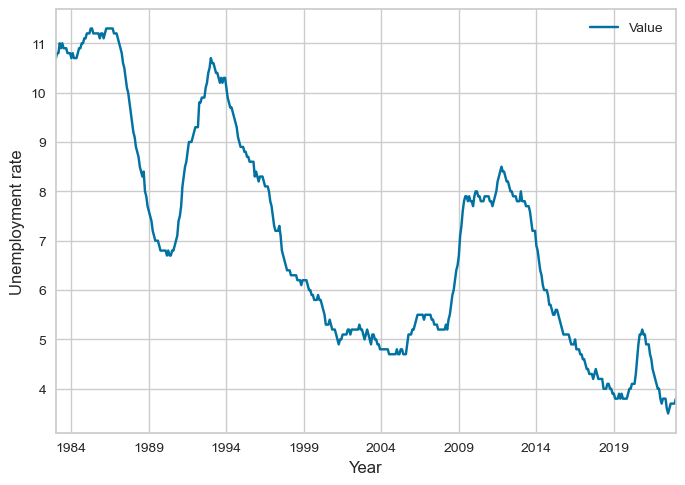

<Figure size 400x400 with 0 Axes>

In [73]:

df.plot()
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.figure(figsize=(4, 4))
plt.show()

### C. Machine learning model comparision 

In [74]:
# Pycaret algorith
exp = TSForecastingExperiment()
exp.setup(data=df['Value'],session_id=42,fh=12)

# compare models 
exp.compare_models(sort='mae')

,Description,Value
0,session_id,42
1,Target,Value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(481, 1)"
5,Transformed data shape,"(481, 1)"
6,Transformed train set shape,"(469, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,2.7966,2.3800,0.3730,0.4349,0.0850,0.0859,-16.6414,0.4533
arima,ARIMA,2.9064,2.5957,0.3878,0.4757,0.0875,0.0875,-3.3225,0.1900
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,3.3212,2.9104,0.4426,0.5330,0.0978,0.0989,-1.8144,2.8333
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,3.3148,2.7497,0.4426,0.5032,0.1019,0.1018,-25.9586,0.6267
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,3.3212,2.9104,0.4426,0.5330,0.0978,0.0989,-1.8144,0.5400
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,3.3148,2.7497,0.4426,0.5032,0.1019,0.1018,-25.9586,0.4267
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,3.3234,2.9120,0.4429,0.5333,0.0978,0.0990,-1.8176,0.4033
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,3.3770,2.9608,0.4499,0.5420,0.0993,0.1015,-2.2861,0.3467
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,3.4382,2.9975,0.4581,0.5488,0.1011,0.1028,-1.9872,0.4633
croston,Croston,3.4510,2.8721,0.4599,0.5252,0.1035,0.1065,-9.1371,0.0467


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=ElasticNet(random_state=42), sp=2,
                    window_length=2)

In [86]:
## Create a model manually
model = exp.create_model("en_cds_dt")
model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-01,3.3189,2.4835,0.4459,0.4557,0.1162,0.1096,-49.6789
1,2020-01,3.8842,3.6441,0.5138,0.6616,0.1026,0.1119,-0.9975
2,2021-01,1.1867,1.0123,0.1594,0.1874,0.0362,0.0363,0.7521
Mean,NaT,2.7966,2.3800,0.3730,0.4349,0.0850,0.0859,-16.6414
SD,NaT,1.1615,1.0769,0.1536,0.1941,0.0350,0.0351,23.3719


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=ElasticNet(random_state=42), sp=2,
                    window_length=2)

In [87]:
y_train = exp.get_config("y_train")
#y_train[0:int(len(df)*0.80)]

In [88]:
y_predict = exp.predict_model(model)
#plot_series(df['Value'], y_train, y_predict, labels=['All', 'Train', 'Test Predictions'])
#plt.grid()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ElasticNet,1.8469,1.4553,0.2511,0.2706,0.0686,0.0659,-7.7891


In [89]:
tuned_model = exp.tune_model(model)
tuned_model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-01,1.4012,1.0858,0.1882,0.1992,0.0492,0.0478,-8.6876
1,2020-01,5.4492,4.8430,0.7208,0.8792,0.1457,0.1628,-2.5281
2,2021-01,2.8787,2.4105,0.3866,0.4462,0.0928,0.0872,-0.4054
Mean,NaT,3.2430,2.7798,0.4319,0.5082,0.0959,0.0993,-3.8737
SD,NaT,1.6726,1.5559,0.2198,0.2810,0.0395,0.0477,3.5125


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished


BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=ElasticNet(random_state=42), sp=2,
                    window_length=2)

In [90]:
exp.predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ElasticNet,1.8469,1.4553,0.2511,0.2706,0.0686,0.0659,-7.7891


,y_pred
2022-02,3.9410
2022-03,3.9233
2022-04,3.9565
2022-05,3.9610
2022-06,3.9667
2022-07,3.9688
2022-08,3.9646
2022-09,3.9625
2022-10,3.9536
2022-11,3.9485


In [91]:
# Finalize Model
final_model = exp.finalize_model(tuned_model)
# Future Predictions
y_pred_future = exp.predict_model(final_model, verbose=False)

In [92]:
y_pred_future

,y_pred
2023-02,3.7849
2023-03,3.8112
2023-04,3.8080
2023-05,3.8144
2023-06,3.8083
2023-07,3.8072
2023-08,3.7975
2023-09,3.7928
2023-10,3.7806
2023-11,3.7739


###  D. LSTM model analysis 


###  D.1 Reading the input files 

In [109]:

# Reading the data file 
df=pd.read_csv("uk.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

###  D.2 Rolling means 6 months 

In [110]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(6,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-6:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_6_days=df_train.tail(6)
final_df=past_6_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(6,input_data.shape[0]):
    x_test.append(input_data[i-6:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_6=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_6["Upper_Bound"]=final_pred_6["Closing_Price"]+interval
final_pred_6["Lower_Bound"]=final_pred_6["Closing_Price"]-interval


print(final_pred_6)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
378/378 [==============================] - 8s 7ms/step - loss: 0.0075
Epoch 2/3
378/378 [==============================] - 3s 7ms/step - loss: 0.0030
Epoch 3/3
1/1 [==============================] - 0s 43ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       3.668976     3.676934     3.661018
1       3.675560     3.683519     3.667602
2       3.673693     3.681651     3.665735
3       3.668598     3.676556     3.660639
4       3.664082     3.672040     3.656123
The Mean Squared Error is 0.071107
The Root Mean Squared Error is 0.071107


###  D.3 Rolling means 3 months 

In [115]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(3,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-3:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_3_days=df_train.tail(3)
final_df=past_3_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(3,input_data.shape[0]):
    x_test.append(input_data[i-3:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_3=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_3["Upper_Bound"]=final_pred_3["Closing_Price"]+interval
final_pred_3["Lower_Bound"]=final_pred_3["Closing_Price"]-interval


print(final_pred_3)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
381/381 [==============================] - 8s 6ms/step - loss: 0.0121
Epoch 2/3
381/381 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 3/3
1/1 [==============================] - 0s 125ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       3.730059     3.765470     3.694648
1       3.735987     3.771399     3.700576
2       3.748037     3.783448     3.712626
3       3.766800     3.802212     3.731389
4       3.777689     3.813100     3.742278
The Mean Squared Error is 0.090801
The Root Mean Squared Error is 0.090801


###  D.4 Rolling means - 1 month

In [114]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(1,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-1:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_1_days=df_train.tail(1)
final_df=past_1_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(1,input_data.shape[0]):
    x_test.append(input_data[i-1:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_1=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_1["Upper_Bound"]=final_pred_1["Closing_Price"]+interval
final_pred_1["Lower_Bound"]=final_pred_1["Closing_Price"]-interval


print(final_pred_1)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
383/383 [==============================] - 11s 7ms/step - loss: 0.0223
Epoch 2/3
383/383 [==============================] - 2s 6ms/step - loss: 5.6701e-04
Epoch 3/3
1/1 [==============================] - 0s 30ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       3.736159     3.830127     3.642192
1       3.771352     3.865320     3.677385
2       3.805645     3.899612     3.711678
3       3.839099     3.933066     3.745132
4       3.871770     3.965738     3.777803
The Mean Squared Error is 0.049590
The Root Mean Squared Error is 0.049590


#  5. Unempolyment rate in Canada

### A. Reading the input files 

In [116]:

# Reading the data file 
df=pd.read_csv("canada.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

### B. Plot analysis 

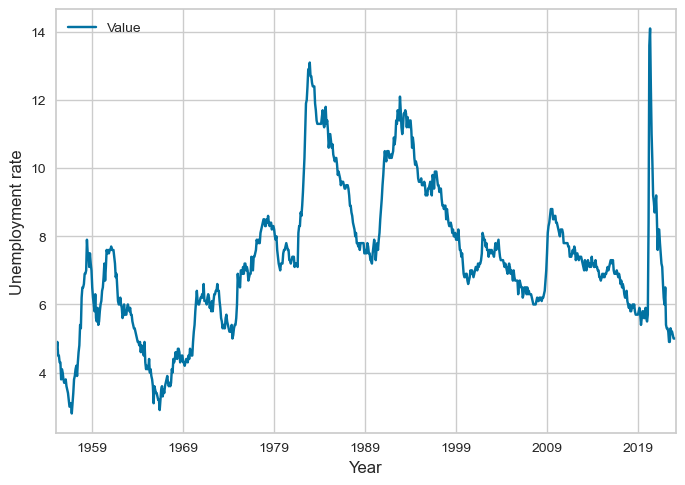

<Figure size 400x400 with 0 Axes>

In [117]:

df.plot()
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.figure(figsize=(4, 4))
plt.show()

### C. Machine learning model comparision 

In [118]:
# Pycaret algorith
exp = TSForecastingExperiment()
exp.setup(data=df['Value'],session_id=42,fh=12)

# compare models 
exp.compare_models(sort='mae')

,Description,Value
0,session_id,42
1,Target,Value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(819, 1)"
5,Transformed data shape,"(819, 1)"
6,Transformed train set shape,"(807, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.7019,1.6003,1.0865,1.4656,0.1208,0.1297,-0.2185,0.5033
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.6950,1.6687,1.0920,1.5560,0.1301,0.1317,-0.4941,1.5467
auto_arima,Auto ARIMA,1.7256,1.5668,1.1001,1.4357,0.1243,0.1287,-0.1715,77.8633
naive,Naive Forecaster,1.7459,1.6884,1.1222,1.5690,0.1311,0.1346,-0.4771,7.6367
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.7616,1.5805,1.1247,1.4545,0.1312,0.1336,-0.2127,0.5767
theta,Theta Forecaster,1.7484,1.7026,1.1248,1.5841,0.1315,0.1347,-0.5160,3.9300
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.8055,1.7192,1.1629,1.6047,0.1388,0.1404,-0.5824,0.4867
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.8480,1.6223,1.1831,1.5035,0.1482,0.1449,-0.3930,0.4967
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8449,1.6971,1.1901,1.5910,0.1463,0.1438,-0.6304,0.7333
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.8487,1.7441,1.1944,1.6403,0.1495,0.1461,-0.7850,0.7367


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [9, 8, 7,
                                                                        6, 5, 4,
                                                                        3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=42), sp=9,
                    window_length=9)

In [130]:
## Create a model manually
model = exp.create_model("ada_cds_dt")
model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,0.7876,0.8725,0.4944,0.7710,0.0764,0.0786,-0.0023
1,2020-03,3.2581,3.1732,2.0349,2.8021,0.1736,0.2020,-0.9119
2,2021-03,1.0601,0.7551,0.7302,0.8238,0.1123,0.1086,0.2588
Mean,NaT,1.7019,1.6003,1.0865,1.4656,0.1208,0.1297,-0.2185
SD,NaT,1.1060,1.1132,0.6775,0.9453,0.0401,0.0525,0.5018


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [9, 8, 7,
                                                                        6, 5, 4,
                                                                        3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=42), sp=9,
                    window_length=9)

In [131]:
y_train = exp.get_config("y_train")
#y_train[0:int(len(df)*0.80)]

In [132]:
y_predict = exp.predict_model(model)
#plot_series(df['Value'], y_train, y_predict, labels=['All', 'Train', 'Test Predictions'])
#plt.grid()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,str,2.0460,1.3493,1.4510,1.5017,0.2862,0.2482,-117.0884


In [133]:
tuned_model = exp.tune_model(model)
tuned_model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,0.8077,0.9132,0.5070,0.8070,0.0781,0.0807,-0.0980
1,2020-03,3.2150,3.1208,2.0079,2.7558,0.1713,0.1989,-0.8493
2,2021-03,1.3463,1.0424,0.9273,1.1372,0.1516,0.1358,-0.4125
Mean,NaT,1.7897,1.6921,1.1474,1.5666,0.1337,0.1384,-0.4533
SD,NaT,1.0316,1.0116,0.6322,0.8516,0.0401,0.0483,0.3080


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.9s finished


BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [9, 8, 7,
                                                                        6, 5, 4,
                                                                        3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=42), sp=9,
                    window_length=9)

In [134]:
exp.predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,str,2.0460,1.3493,1.4510,1.5017,0.2862,0.2482,-117.0884


,y_pred
2022-04,5.9888
2022-05,6.9589
2022-06,6.3302
2022-07,6.0503
2022-08,6.0977
2022-09,6.5730
2022-10,6.6036
2022-11,6.8922
2022-12,7.0433
2023-01,6.6820


In [135]:
# Finalize Model
final_model = exp.finalize_model(tuned_model)
# Future Predictions
y_pred_future = exp.predict_model(final_model, verbose=False)

In [136]:
y_pred_future

,y_pred
2023-04,5.1518
2023-05,5.1989
2023-06,5.1085
2023-07,5.1041
2023-08,5.1190
2023-09,5.1688
2023-10,5.1585
2023-11,5.1163
2023-12,5.1515
2024-01,5.2168


###  D. LSTM model analysis 


###  D.1 Reading the input files 

In [137]:

# Reading the data file 
df=pd.read_csv("canada.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

###  D.2 Rolling means 6 months 

In [138]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(6,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-6:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_6_days=df_train.tail(6)
final_df=past_6_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(6,input_data.shape[0]):
    x_test.append(input_data[i-6:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_6=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_6["Upper_Bound"]=final_pred_6["Closing_Price"]+interval
final_pred_6["Lower_Bound"]=final_pred_6["Closing_Price"]-interval


print(final_pred_6)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
649/649 [==============================] - 12s 10ms/step - loss: 0.0047
Epoch 2/3
649/649 [==============================] - 4s 7ms/step - loss: 0.0027
Epoch 3/3
1/1 [==============================] - 0s 70ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       5.113555     5.228595     4.998516
1       5.141922     5.256962     5.026883
2       5.184781     5.299821     5.069742
3       5.230418     5.345458     5.115379
4       5.276085     5.391125     5.161046
The Mean Squared Error is 0.083027
The Root Mean Squared Error is 0.083027


###  D.3 Rolling means 3 months 

In [139]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(3,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-3:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_3_days=df_train.tail(3)
final_df=past_3_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(3,input_data.shape[0]):
    x_test.append(input_data[i-3:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_3=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_3["Upper_Bound"]=final_pred_3["Closing_Price"]+interval
final_pred_3["Lower_Bound"]=final_pred_3["Closing_Price"]-interval


print(final_pred_3)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
652/652 [==============================] - 9s 7ms/step - loss: 0.0044
Epoch 2/3
652/652 [==============================] - 4s 5ms/step - loss: 0.0019
Epoch 3/3
1/1 [==============================] - 0s 50ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       4.658464     5.107546     4.209382
1       4.565814     5.014896     4.116732
2       4.409305     4.858387     3.960223
3       4.194978     4.644060     3.745896
4       4.040113     4.489195     3.591031
The Mean Squared Error is 0.095916
The Root Mean Squared Error is 0.095916


###  D.4 Rolling means - 1 month

In [140]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(1,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-1:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_1_days=df_train.tail(1)
final_df=past_1_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(1,input_data.shape[0]):
    x_test.append(input_data[i-1:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_1=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_1["Upper_Bound"]=final_pred_1["Closing_Price"]+interval
final_pred_1["Lower_Bound"]=final_pred_1["Closing_Price"]-interval


print(final_pred_1)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
654/654 [==============================] - 9s 4ms/step - loss: 0.0084
Epoch 2/3
654/654 [==============================] - 3s 5ms/step - loss: 9.1985e-04
Epoch 3/3
1/1 [==============================] - 0s 16ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       5.071638     5.254119     4.889158
1       5.140826     5.323307     4.958346
2       5.207696     5.390177     5.025216
3       5.272372     5.454853     5.089892
4       5.334968     5.517449     5.152487
The Mean Squared Error is 0.058977
The Root Mean Squared Error is 0.058977


#  6. Unempolyment rate in France

### A. Reading the input files 

In [141]:

# Reading the data file 
df=pd.read_csv("france.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

### B. Plot analysis 

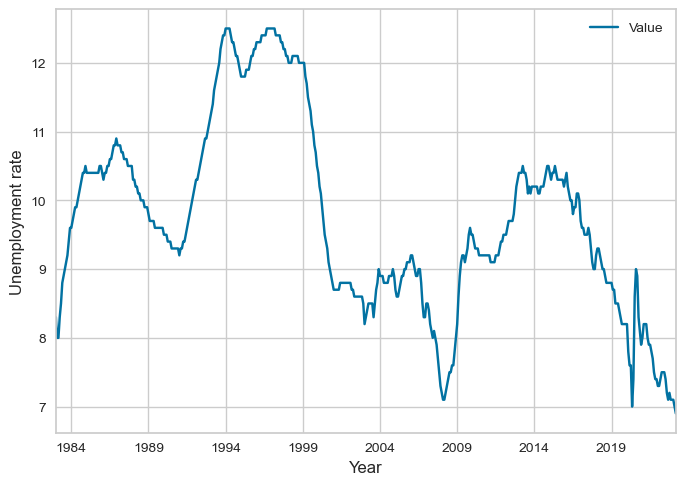

<Figure size 400x400 with 0 Axes>

In [142]:

df.plot()
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.figure(figsize=(4, 4))
plt.show()

### C. Machine learning model comparision 

In [143]:
# Pycaret algorith
exp = TSForecastingExperiment()
exp.setup(data=df['Value'],session_id=42,fh=12)

# compare models 
exp.compare_models(sort='mae')

,Description,Value
0,session_id,42
1,Target,Value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(483, 1)"
5,Transformed data shape,"(483, 1)"
6,Transformed train set shape,"(471, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.1058,0.9945,0.3943,0.4635,0.0492,0.0494,-0.5476,0.7633
par_cds_dt,Passive Aggressive w/ Cond. Deseasonalize & Detrending,1.1330,0.9875,0.4030,0.4594,0.0500,0.0505,-0.5957,0.3067
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.1451,1.0366,0.4079,0.4827,0.0510,0.0516,-0.5709,0.3000
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.1659,1.0316,0.4150,0.4802,0.0516,0.0516,-0.8928,0.5167
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.1999,1.0491,0.4278,0.4889,0.0536,0.0538,-0.6750,0.4067
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.4789,1.3087,0.5279,0.6108,0.0663,0.0653,-2.4584,0.5633
theta,Theta Forecaster,1.5232,1.3464,0.5440,0.6285,0.0682,0.0677,-2.3430,5.2900
arima,ARIMA,1.5308,1.3285,0.5455,0.6187,0.0675,0.0701,-1.5854,0.2933
naive,Naive Forecaster,1.5549,1.3740,0.5556,0.6415,0.0698,0.0690,-2.5576,6.3200
snaive,Seasonal Naive Forecaster,1.5545,1.4075,0.5556,0.6576,0.0708,0.0683,-3.2064,0.1933


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [7, 6, 5,
                                                                        4, 3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                    sp=7, window_length=7)

In [155]:
## Create a model manually
model = exp.create_model("et_cds_dt")
model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,0.8162,0.7392,0.2879,0.3430,0.0358,0.0349,-0.6870
1,2020-03,1.6905,1.5202,0.5994,0.7042,0.0723,0.0749,-0.5827
2,2021-03,0.8108,0.7242,0.2956,0.3433,0.0395,0.0385,-0.3732
Mean,NaT,1.1058,0.9945,0.3943,0.4635,0.0492,0.0494,-0.5476
SD,NaT,0.4134,0.3717,0.1450,0.1702,0.0164,0.0181,0.1305


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [7, 6, 5,
                                                                        4, 3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                    sp=7, window_length=7)

In [156]:
y_train = exp.get_config("y_train")
#y_train[0:int(len(df)*0.80)]

In [157]:
y_predict = exp.predict_model(model)
#plot_series(df['Value'], y_train, y_predict, labels=['All', 'Train', 'Test Predictions'])
#plt.grid()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ExtraTreesRegressor,0.6215,0.5516,0.2282,0.2622,0.0321,0.0315,-0.7312


In [158]:
tuned_model = exp.tune_model(model)
tuned_model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,1.8461,1.5692,0.6513,0.7280,0.0807,0.0767,-6.6014
1,2020-03,1.2504,1.2250,0.4433,0.5675,0.0547,0.0550,-0.0277
2,2021-03,1.0533,0.9437,0.3841,0.4474,0.0514,0.0496,-1.3320
Mean,NaT,1.3833,1.2460,0.4929,0.5810,0.0622,0.0605,-2.6537
SD,NaT,0.3370,0.2558,0.1146,0.1150,0.0131,0.0117,2.8418


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.6s finished


BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [7, 6, 5,
                                                                        4, 3, 2,
                                                                        1]},
                                                   n_jobs=1)],
                    regressor=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                    sp=7, window_length=7)

In [159]:
exp.predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ExtraTreesRegressor,0.6215,0.5516,0.2282,0.2622,0.0321,0.0315,-0.7312


,y_pred
2022-04,7.3929
2022-05,7.4078
2022-06,7.4191
2022-07,7.4081
2022-08,7.4163
2022-09,7.3868
2022-10,7.3943
2022-11,7.4092
2022-12,7.4093
2023-01,7.4030


In [160]:
# Finalize Model
final_model = exp.finalize_model(tuned_model)
# Future Predictions
y_pred_future = exp.predict_model(final_model, verbose=False)

In [161]:
y_pred_future

,y_pred
2023-04,6.8394
2023-05,6.8396
2023-06,6.8554
2023-07,6.8935
2023-08,6.9605
2023-09,6.9661
2023-10,6.9850
2023-11,7.0158
2023-12,7.0835
2024-01,7.1134


###  D. LSTM model analysis 


###  D.1 Reading the input files 

In [151]:

# Reading the data file 
df=pd.read_csv("france.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

###  D.2 Rolling means 6 months 

In [152]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(6,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-6:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_6_days=df_train.tail(6)
final_df=past_6_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(6,input_data.shape[0]):
    x_test.append(input_data[i-6:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_6=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_6["Upper_Bound"]=final_pred_6["Closing_Price"]+interval
final_pred_6["Lower_Bound"]=final_pred_6["Closing_Price"]-interval


print(final_pred_6)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
380/380 [==============================] - 8s 7ms/step - loss: 0.0073
Epoch 2/3
380/380 [==============================] - 3s 7ms/step - loss: 0.0039
Epoch 3/3
1/1 [==============================] - 0s 41ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       7.247284     7.342489     7.152079
1       7.266039     7.361244     7.170834
2       7.294479     7.389684     7.199274
3       7.336610     7.431815     7.241405
4       7.381409     7.476614     7.286204
The Mean Squared Error is 0.101195
The Root Mean Squared Error is 0.101195


###  D.3 Rolling means 3 months 

In [153]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(3,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-3:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_3_days=df_train.tail(3)
final_df=past_3_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(3,input_data.shape[0]):
    x_test.append(input_data[i-3:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_3=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_3["Upper_Bound"]=final_pred_3["Closing_Price"]+interval
final_pred_3["Lower_Bound"]=final_pred_3["Closing_Price"]-interval


print(final_pred_3)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
383/383 [==============================] - 11s 6ms/step - loss: 0.0123
Epoch 2/3
383/383 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 3/3
1/1 [==============================] - 0s 29ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       7.335383     7.578344     7.092423
1       7.363325     7.606286     7.120364
2       7.432979     7.675940     7.190018
3       7.588289     7.831249     7.345328
4       7.648991     7.891952     7.406030
The Mean Squared Error is 0.095707
The Root Mean Squared Error is 0.095707


###  D.4 Rolling means - 1 month

In [154]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(1,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-1:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_1_days=df_train.tail(1)
final_df=past_1_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(1,input_data.shape[0]):
    x_test.append(input_data[i-1:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_1=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_1["Upper_Bound"]=final_pred_1["Closing_Price"]+interval
final_pred_1["Lower_Bound"]=final_pred_1["Closing_Price"]-interval


print(final_pred_1)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
385/385 [==============================] - 7s 6ms/step - loss: 0.0194
Epoch 2/3
385/385 [==============================] - 3s 7ms/step - loss: 6.4175e-04
Epoch 3/3
1/1 [==============================] - 0s 30ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       7.026775     7.087864     6.965686
1       7.051467     7.112556     6.990379
2       7.074274     7.135363     7.013185
3       7.095368     7.156456     7.034279
4       7.114902     7.175991     7.053814
The Mean Squared Error is 0.053797
The Root Mean Squared Error is 0.053797


#  7. Unempolyment rate in Germany

### A. Reading the input files 

In [162]:

# Reading the data file 
df=pd.read_csv("germany.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

### B. Plot analysis 

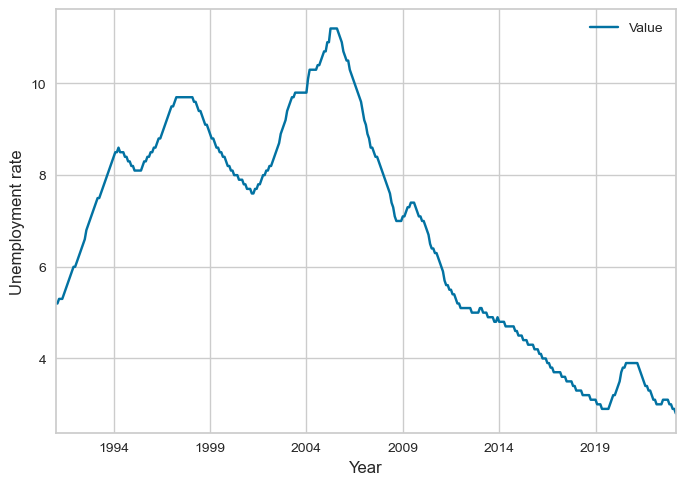

<Figure size 400x400 with 0 Axes>

In [163]:

df.plot()
plt.xlabel('Year')
plt.ylabel('Unemployment rate')
plt.figure(figsize=(4, 4))
plt.show()

### C. Machine learning model comparision 

In [164]:
# Pycaret algorith
exp = TSForecastingExperiment()
exp.setup(data=df['Value'],session_id=42,fh=12)

# compare models 
exp.compare_models(sort='mae')

,Description,Value
0,session_id,42
1,Target,Value
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(387, 1)"
5,Transformed data shape,"(387, 1)"
6,Transformed train set shape,"(375, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.9185,1.7369,0.2303,0.2592,0.0684,0.0676,-1.8724,0.4367
arima,ARIMA,2.5017,2.3585,0.2997,0.3520,0.0913,0.0889,-2.7849,0.3300
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,2.6442,2.3021,0.3163,0.3431,0.0934,0.0892,-3.4332,0.3300
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,2.6442,2.3021,0.3163,0.3431,0.0934,0.0892,-3.4332,4.3233
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,2.6458,2.3237,0.3165,0.3464,0.0949,0.0892,-3.0839,0.2400
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,2.6475,2.3049,0.3167,0.3436,0.0935,0.0893,-3.4510,0.2400
exp_smooth,Exponential Smoothing,2.7702,2.6956,0.3319,0.4023,0.0995,0.0966,-4.0327,0.2233
auto_arima,Auto ARIMA,2.7870,2.7023,0.3340,0.4033,0.1002,0.0973,-4.0271,3.9800
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,2.8979,2.5094,0.3468,0.3740,0.1013,0.0980,-4.9789,0.2833
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,3.0556,2.6335,0.3658,0.3925,0.1062,0.1036,-6.1108,0.2300


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=42), sp=2,
                    window_length=2)

In [176]:
## Create a model manually
model = exp.create_model("ada_cds_dt")
model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,1.6254,1.4430,0.1968,0.2164,0.0651,0.0637,-0.6096
1,2020-03,2.1741,1.8749,0.2610,0.2794,0.0673,0.0700,-4.6201
2,2021-03,1.9561,1.8928,0.2330,0.2818,0.0728,0.0691,-0.3874
Mean,NaT,1.9185,1.7369,0.2303,0.2592,0.0684,0.0676,-1.8724
SD,NaT,0.2256,0.2079,0.0263,0.0303,0.0033,0.0028,1.9450


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=42), sp=2,
                    window_length=2)

In [177]:
y_train = exp.get_config("y_train")
#y_train[0:int(len(df)*0.80)]

In [178]:
y_predict = exp.predict_model(model)
#plot_series(df['Value'], y_train, y_predict, labels=['All', 'Train', 'Test Predictions'])
#plt.grid()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,str,0.5290,0.5359,0.0634,0.0798,0.0209,0.0211,0.2360


In [179]:
tuned_model = exp.tune_model(model)
tuned_model

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-03,0.8042,0.7306,0.0974,0.1096,0.0321,0.0315,0.5874
1,2020-03,0.9759,0.9078,0.1172,0.1353,0.0304,0.0309,-0.3175
2,2021-03,7.7637,7.1062,0.9248,1.0579,0.2868,0.2408,-18.5564
Mean,NaT,3.1813,2.9148,0.3798,0.4342,0.1165,0.1011,-6.0955
SD,NaT,3.2411,2.9646,0.3855,0.4411,0.1204,0.0988,8.8189


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.7s finished


BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=42), sp=2,
                    window_length=2)

In [180]:
exp.predict_model(tuned_model)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,str,0.5290,0.5359,0.0634,0.0798,0.0209,0.0211,0.2360


,y_pred
2022-04,3.0022
2022-05,3.0309
2022-06,3.0196
2022-07,2.9999
2022-08,2.9885
2022-09,2.9688
2022-10,2.9575
2022-11,2.9378
2022-12,2.9264
2023-01,2.9067


In [181]:
# Finalize Model
final_model = exp.finalize_model(tuned_model)
# Future Predictions
y_pred_future = exp.predict_model(final_model, verbose=False)

In [182]:
y_pred_future

,y_pred
2023-04,2.8359
2023-05,2.8924
2023-06,2.9884
2023-07,2.9679
2023-08,2.9565
2023-09,2.9360
2023-10,2.9247
2023-11,2.9042
2023-12,2.8928
2024-01,2.8723


###  D. LSTM model analysis 


###  D.1 Reading the input files 

In [172]:

# Reading the data file 
df=pd.read_csv("germany.csv")

# Rename the column
df=df.rename(columns={"TIME":"Date"})

# Extract the required columns
df=df.loc[:,["Date","Value"]]

# set "Date" column as index
df=df.set_index("Date")

# Keep index as datetime index
df.index = pd.to_datetime(df.index)

###  D.2 Rolling means 6 months 

In [173]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(6,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-6:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_6_days=df_train.tail(6)
final_df=past_6_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(6,input_data.shape[0]):
    x_test.append(input_data[i-6:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_6=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_6["Upper_Bound"]=final_pred_6["Closing_Price"]+interval
final_pred_6["Lower_Bound"]=final_pred_6["Closing_Price"]-interval


print(final_pred_6)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
303/303 [==============================] - 11s 11ms/step - loss: 0.0084
Epoch 2/3
303/303 [==============================] - 3s 11ms/step - loss: 0.0029
Epoch 3/3
1/1 [==============================] - 0s 31ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       2.970667     3.015110     2.926224
1       2.945509     2.989952     2.901066
2       2.924968     2.969411     2.880525
3       2.916385     2.960828     2.871942
4       2.907409     2.951852     2.862966
The Mean Squared Error is 0.136774
The Root Mean Squared Error is 0.136774


###  D.3 Rolling means 3 months 

In [174]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(3,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-3:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_3_days=df_train.tail(3)
final_df=past_3_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(3,input_data.shape[0]):
    x_test.append(input_data[i-3:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_3=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_3["Upper_Bound"]=final_pred_3["Closing_Price"]+interval
final_pred_3["Lower_Bound"]=final_pred_3["Closing_Price"]-interval


print(final_pred_3)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
306/306 [==============================] - 7s 5ms/step - loss: 0.0111
Epoch 2/3
306/306 [==============================] - 2s 5ms/step - loss: 0.0011
Epoch 3/3
1/1 [==============================] - 0s 31ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       2.890327     2.974793     2.805860
1       2.837133     2.921599     2.752666
2       2.823979     2.908445     2.739512
3       2.797423     2.881890     2.712957
4       2.760514     2.844980     2.676047
The Mean Squared Error is 0.108938
The Root Mean Squared Error is 0.108938


###  D.4 Rolling means - 1 month

In [175]:

# Split the data - Test and Train

df_train=pd.DataFrame(df["Value"][0:int(len(df)*0.80)])
df_test=pd.DataFrame(df["Value"][int(len(df)*0.80):int(len(df))])

# Standardisation of values #Scale the data

Scaler=MinMaxScaler(feature_range=(0,1))
df_train_array=Scaler.fit_transform(df_train)

#Create the scaled training data set

x_train=[]
y_train=[]

#for i in range(100,df_train_array.shape[0]):
for i in range(1,df_train_array.shape[0]):
    #x_train.append(df_train_array[i-100:i]) #  #Will conaint 100 values (0-99)
    x_train.append(df_train_array[i-1:i]) #  #Will conaint 100 values (0-99)
    y_train.append(df_train_array[i,0])  #Will contain the 101 th value (100)
    
x_train,y_train =np.array(x_train),np.array(y_train)

#Build the LSTM model

model=Sequential()

model.add(LSTM(units=50,activation='relu',return_sequences=True,
              input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=3)

#Create the testing data set
#Tate last 100 days of train data for refercne for test data

#past_100_days=df_train.tail(100)
#final_df=past_100_days.append(df_test,ignore_index=True)

past_1_days=df_train.tail(1)
final_df=past_1_days.append(df_test,ignore_index=True)

#Convert the data to a numpy array
input_data=Scaler.fit_transform(final_df)

#Create the data set x_test and y_test
x_test=[]
y_test=[]

for i in range(1,input_data.shape[0]):
    x_test.append(input_data[i-1:i])
    y_test.append(input_data[i,0])
    
x_test,y_test =np.array(x_test),np.array(y_test)

# making predictions
y_predicted=model.predict(x_test)

#y_predicted = Scaler.inverse_transform(y_predicted)
y_predicted_inversed = Scaler.inverse_transform(y_predicted)

# Create a new dataframe with only the 'Close column 
data = df.filter(['Value'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

new_df =pd.DataFrame(df["Value"].copy(), columns=["Value"])

train_size = int(len(new_df)*0.8)

#Get the model's predicted price values for the x_future next 5 days

X_FUTURE = 5
predictions = np.array([])
last = x_test[-1]
for i in range(X_FUTURE):
    curr_prediction = model.predict(np.array([last]))
    #print(curr_prediction)
    last = np.concatenate([last[1:], curr_prediction])
    predictions = np.concatenate([predictions, curr_prediction[0]])
predictions = Scaler.inverse_transform([predictions])[0]

#final_pred=pd.DataFrame(data=predictions,columns=prediction)
final_pred_1=pd.DataFrame({'Closing_Price':predictions })

# # calculate 95% gaussian prediction interval
# interval = 1.96 * predictions.std()
# lower, upper = predictions.mean() - interval, predictions.mean() + interval

# #return lower, predictions.mean(), upper
# final_pred["lower"]=predictions.mean() - interval
# final_pred["upper"]=predictions.mean() + interval

# calculate 95% gaussian prediction interval
interval = 1.96 * predictions.std()
#lower, upper = predictions.mean() - interval, predictions.mean() + interval

#return lower, predictions.mean(), upper
#final_pred["lower"]=predictions.mean() - interval
#final_pred["upper"]=predictions.mean() + interval
final_pred_1["Upper_Bound"]=final_pred_1["Closing_Price"]+interval
final_pred_1["Lower_Bound"]=final_pred_1["Closing_Price"]-interval


print(final_pred_1)


# Mean Squared Error
mse= mean_squared_error(y_test, y_predicted,squared=False)
print("The Mean Squared Error is %f" %mse)

# Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("The Root Mean Squared Error is %f" %rmse)

Epoch 1/3
308/308 [==============================] - 9s 6ms/step - loss: 0.0227
Epoch 2/3
308/308 [==============================] - 2s 6ms/step - loss: 4.3864e-04
Epoch 3/3
1/1 [==============================] - 0s 31ms/step
   Closing_Price  Upper_Bound  Lower_Bound
0       2.899704     2.900430     2.898978
1       2.899423     2.900149     2.898697
2       2.899155     2.899881     2.898429
3       2.898900     2.899626     2.898174
4       2.898657     2.899383     2.897931
The Mean Squared Error is 0.060764
The Root Mean Squared Error is 0.060764
